This is our code written in `AWS Braket`. We have this braket version of code in preparation for real submission to backends on AWS Braket platform. You are recommended to read [this](HA_noiseless_qiskit.ipynb) for the main story of our work.

In [1]:
# general imports
import numpy as np
import math
import mpmath as mp
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter


from braket.circuits import Circuit, circuit, Instruction
from braket.devices import LocalSimulator

from braket.tracking import Tracker

from HA_utils import get_real_CDF, get_fh_matrix, Assembly_ACDF

In [2]:
tracker = Tracker().start()
device = LocalSimulator()

In [3]:
def fh_evolution(N_sites, t, U, tau, j, step):
    
    qc = Circuit()
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.xx(2*i,2*i+1,theta)
            qc.yy(2*i,2*i+1,theta)

            qc.xx(2*i+N_sites,2*i+1+N_sites,theta)
            qc.yy(2*i+N_sites,2*i+1+N_sites,theta)
            
        for i in range((N_sites-1)//2):
            qc.xx(2*i+1,2*i+2,theta)
            qc.yy(2*i+1,2*i+2,theta)

            qc.xx(2*i+N_sites+1,2*i+2+N_sites,theta)
            qc.yy(2*i+N_sites+1,2*i+2+N_sites,theta)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.zz(i,i+N_sites,gamma)
    return qc

In [4]:
def czz_gate(angle):
    qc = Circuit()
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    
    return qc

def cxx_gate(angle):
    qc = Circuit()
    qc.h([1,2])
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.h([1,2])
    return qc

def cyy_gate(angle):
    qc = Circuit()
    qc.rx([1,2],pi/2)
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.rx([1,2],-pi/2)
    
    return qc

In [5]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):
    num_qubits = 2*N_sites+2
    qc = Circuit()

    qc.h([0,1])

    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)





    ## Control-UI gate 

    if initial_state_symmetry:
        for i in range(N_sites):
            if i%2!=0:
                qc.cnot(0,i+2)
            else:
                qc.cnot(0, i+2+N_sites)

        ## CH(0, 2)
        qc.ry(2, -pi/4)
        qc.cz(0, 2)
        qc.ry(2, pi/4)    

        for i in range(2*N_sites-1):
            qc.ccnot(0,2, i+3)
    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.cnot(0,i+2)
            else:
                qc.cnot(0, i+2+N_sites)

    
    ## Control-UR gate, but pass

    ## evolution
    qc.add_circuit(fh_evolution(N_sites, t, U, tau, j, step), range(2,num_qubits))

    # ## Control-UI_dagger gate
    # for i in range(N_sites):
    #     if i%2!=0:
    #         qc.cnot(1,i+2)
    #     else:
    #         qc.cnot(1, i+2+N_sites)

    ## Control-UI_dagger gate(Sym)

    if initial_state_symmetry:
        for i in range(2*N_sites-1):
            qc.ccnot(1,2, i+3)    

        qc.ry(2, -pi/4)
        qc.cz(1, 2)
        qc.ry(2, pi/4)

        for i in range(N_sites):
            if i%2!=0:
                qc.cnot(1,i+2)
            else:
                qc.cnot(1, i+2+N_sites)
    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.cnot(0,i+2)
            else:
                qc.cnot(0, i+2+N_sites)       


    
    
    qc.h([0,1])

    qc.probability(target=range(num_qubits))
    return qc

In [6]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')

    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()

    probs_real = res_real.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_real.keys():
        p00 = probs_real['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_real.keys():
        p01 = probs_real['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_real.keys():
        p10 = probs_real['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_real.keys():
        p11 = probs_real['11'+'0'*2*N_sites]
        
    X = p00+p11-p01-p10 

    probs_imag = res_imag.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_imag.keys():
        p00 = probs_imag['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_imag.keys():
        p01 = probs_imag['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_imag.keys():
        p10 = probs_imag['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_imag.keys():
        p11 = probs_imag['11'+'0'*2*N_sites]
    
    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

In [7]:
def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

In [8]:
def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j], initial_state_symmetry=initial_state_symmetry)
    return Z_list

In [10]:
F_list_import =np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000

In [11]:
N_sites = 4
t = 1
U = 4
step = 10
total_shots = 10000
precision = 20000
initial_state_symmetry = True

fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = pi/(4*np.linalg.norm(fh_matrix))



In [12]:
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=total_shots)
Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step, shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)
ACDF = Assembly_ACDF(Z_list, F_list_import, precision)

CDF = get_real_CDF(N_sites=N_sites, t=t,U=U,tau=tau,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


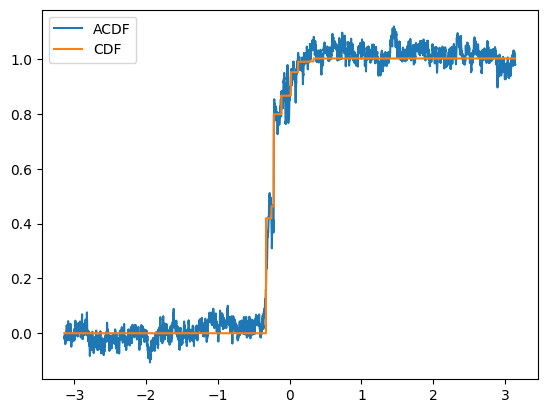

In [13]:
plt.plot(np.linspace(-pi,pi,precision), ACDF,label='ACDF')
plt.plot(np.linspace(-pi,pi,precision), CDF,label='CDF')
plt.legend()